In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# import libraries

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# test tensorflow working status
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision FOrests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision FOrests v1.4.0


In [4]:
# load dataset
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [5]:
# there are 79 feature columns
dataset_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop id column as it is not necessary for model training
dataset_df = dataset_df.drop('Id', axis = 1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
# inspect the types of feature columns
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_20/3150559484.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color = 'g', bins = 100, hist_kws = {'alpha': 0.4});


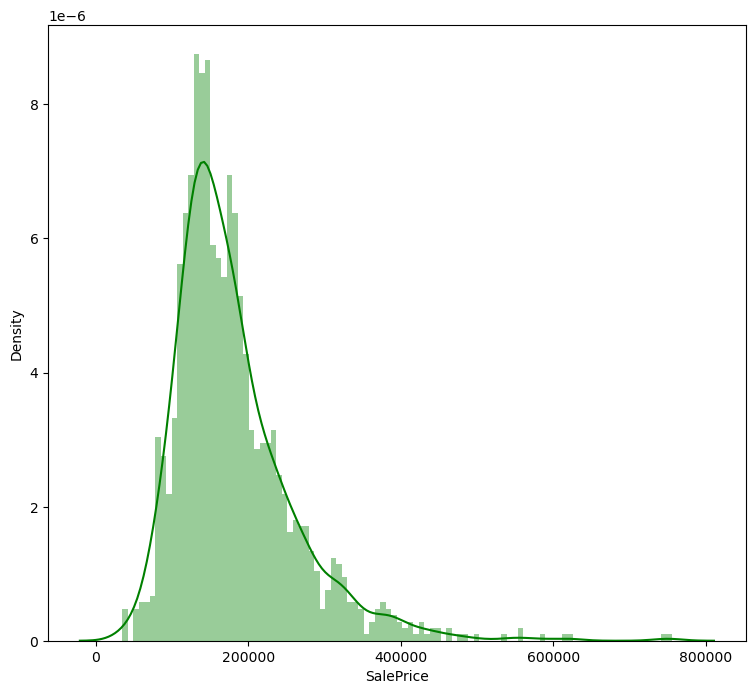

In [8]:
# take look how the house prices are disributed
print(dataset_df['SalePrice'].describe())
plt.figure(figsize = (9, 8))

sns.distplot(dataset_df['SalePrice'], color = 'g', bins = 100, hist_kws = {'alpha': 0.4});

In [9]:
# numerical data distribution
# firstly, list all the types of data from our dataset
# and select only the numerical ones

list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [10]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

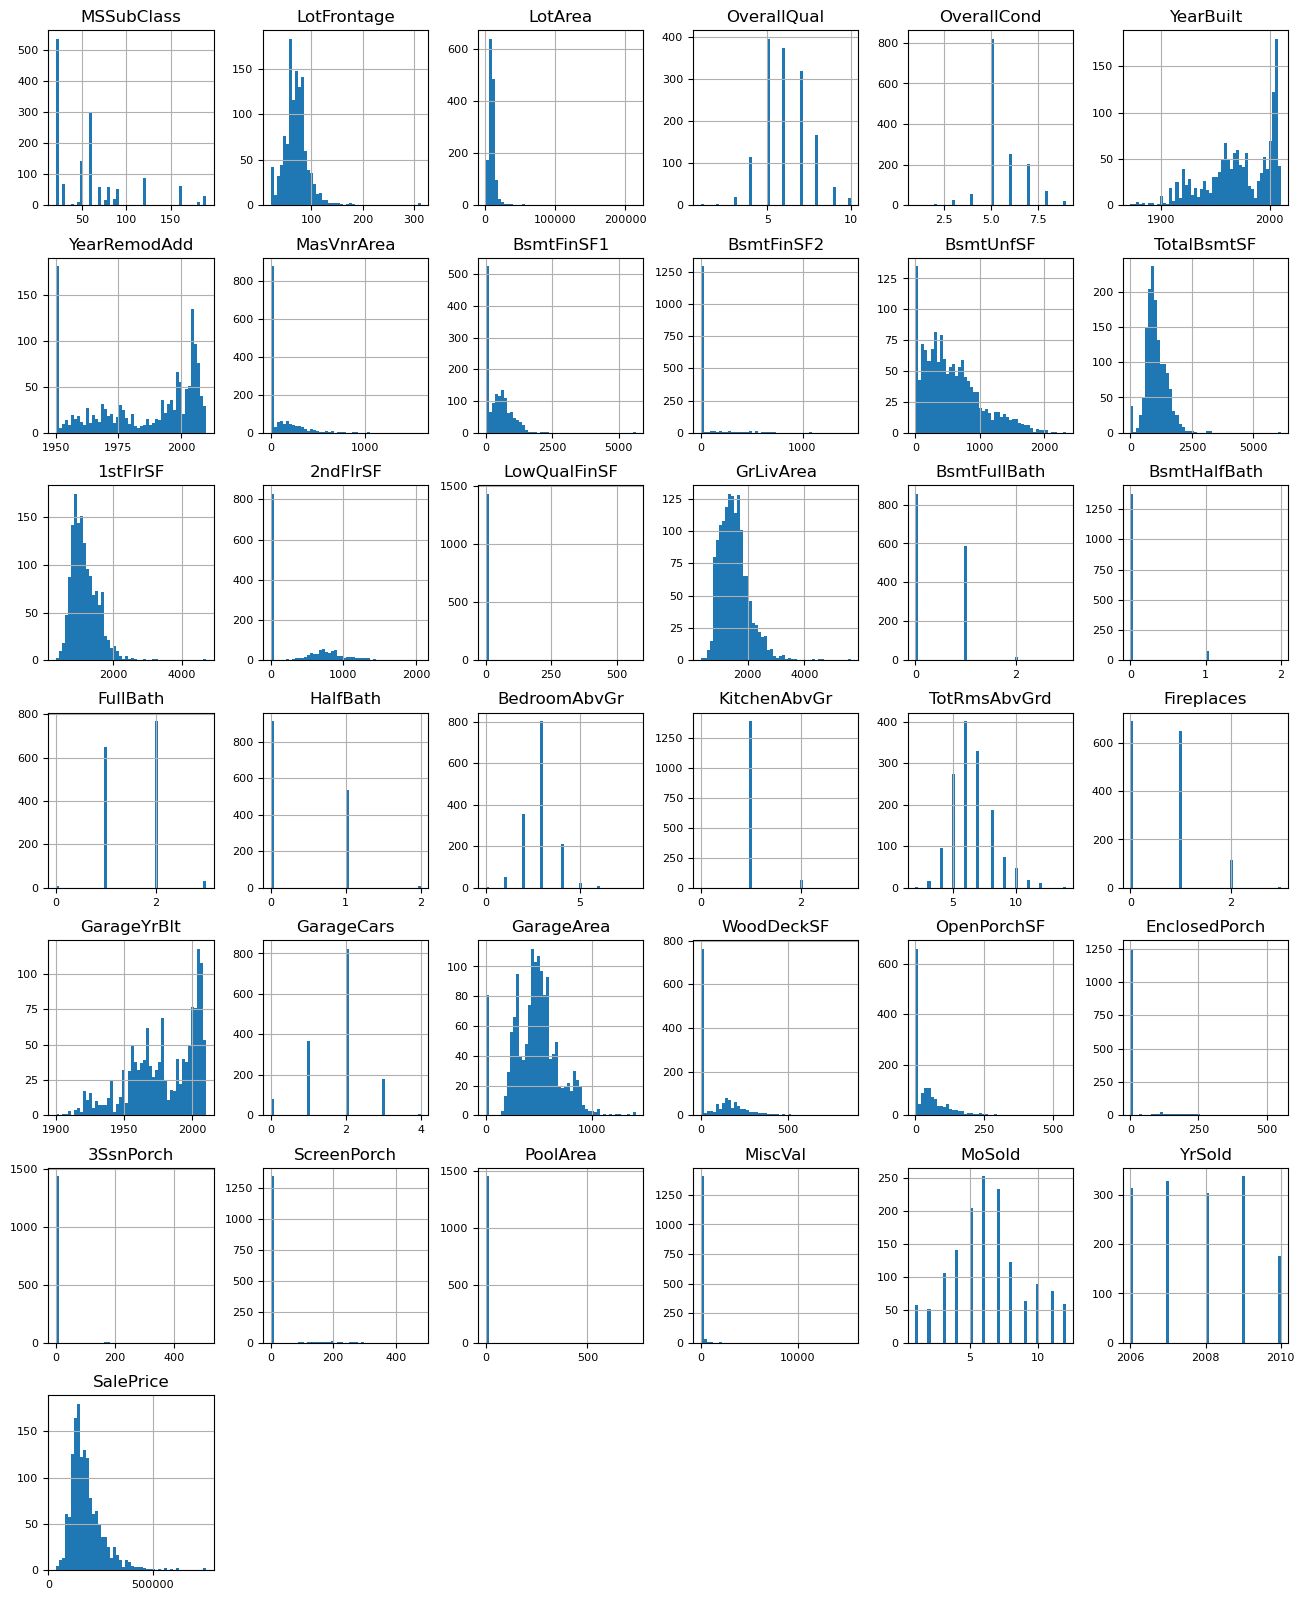

In [11]:
# plot the distribution for all the numerical features
df_num.hist(figsize = (16, 20), bins = 50, xlabelsize = 8, ylabelsize = 8)

## Prepare the dataset

In [12]:
# split the dataset into training and testing datasets

import numpy as np

def split_dataset(dataset, test_ration = 0.30):
    test_indices = np.random.rand(len(dataset)) < test_ration
    return dataset[~test_indices], dataset[test_indices]


In [13]:
train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(len(train_ds_pd), len(valid_ds_pd)))

1008 examples in training, 452 examples in testing.


In [14]:
# convert the dataset from Pandas format
# into TensorFlow format(tf.data.Dataset)
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)

valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)


## MODEL SELECTION

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

And start with the **Random Forest**:

A Random Forest is a collection of Decision Trees, each trained independently on a random subset of the training dataset.

The algorithm is unique in that it is **robust to overfitting** and easy to use


In [15]:
# list the all the avalibale models in TensorFlow Decision Forests
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## Create a Random Forest

to use defaults to create the Random Forest Model while specifying the task type as tfdf.keras.Task.REGRESSION

In [16]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
# optional: use this to include a list of eval metrics
rf.compile(metrics = ['mse'])

Use /tmp/tmp2u1tkpun as temporary training directory


## Train the model

In [17]:
rf.fit(x = train_ds)

Reading training dataset...
Training dataset read in 0:00:05.918193. Found 1008 examples.
Training model...


[INFO 23-08-31 23:07:48.6340 UTC kernel.cc:1243] Loading model from path /tmp/tmp2u1tkpun/model/ with prefix eb7bd2ae795c48db
[INFO 23-08-31 23:07:48.8051 UTC decision_forest.cc:660] Model loaded with 300 root(s), 95754 node(s), and 73 input feature(s).
[INFO 23-08-31 23:07:48.8051 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-31 23:07:48.8051 UTC kernel.cc:1075] Use fast generic engine


Model trained in 0:00:01.359501
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them.

The default number of trees used in the Random Forests is 300.

In [18]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

## Evaluation

Evaluate the model on the Out of bag(OOB) data and validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as valid_ds.

We can also use Out of Bag(OOB) score to validate our RandomForestModel.

To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.

The subset of data that is not chosen is known as Out of Bag data.

OOB score is computed on the OBB data.

The training logs show the Root Mean Squared Error(RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model.
Plot as below

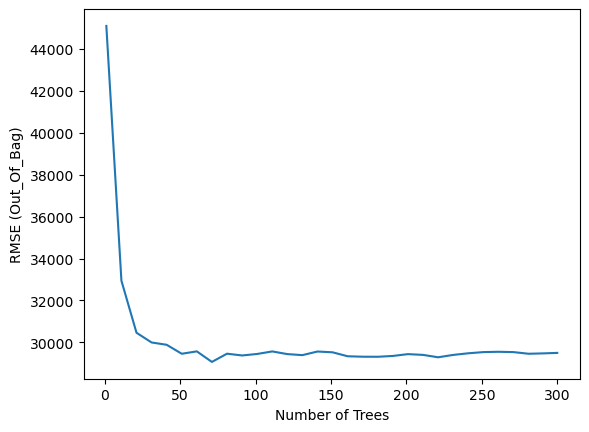

In [19]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of Trees")
plt.ylabel("RMSE (Out_Of_Bag)")
plt.show()

we can also see some general stats on the OBB dataset:

In [20]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1008, accuracy=None, loss=None, rmse=29499.162583816025, ndcg=None, aucs=None, auuc=None, qini=None)

Then, running an evaluation using the validation dataset

In [21]:
evaluation = rf.evaluate(x = valid_ds, return_dict = True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 619ms/step - loss: 0.0000e+00 - mse: 792849984.0000
loss: 0.0000
mse: 792849984.0000


## Variable Importance
variable importances generally indicate how much a feature contributes to the model predictions or quality.

There are several ways to identify important features using TensorFlow Decsion Forests

In [22]:
print(f"Available Variable Importances:")
for importance in inspector.variable_importances().keys():
    print("/t", importance)

Available Variable Importances:
/t NUM_NODES
/t NUM_AS_ROOT
/t INV_MEAN_MIN_DEPTH
/t SUM_SCORE


The larger the importance score for NUM_AS_ROOT, the more impact it has on the outcome of the model

By default, the list is sorted from the most important to the least.

From output we can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature

In [23]:
# display the importance features for the variable importance NUM_AS_ROOT
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 121.0),
 ("GarageCars" (1; #32), 54.0),
 ("ExterQual" (4; #22), 39.0),
 ("Neighborhood" (4; #59), 30.0),
 ("GrLivArea" (1; #38), 19.0),
 ("GarageArea" (1; #31), 8.0),
 ("TotalBsmtSF" (1; #73), 6.0),
 ("YearBuilt" (1; #76), 6.0),
 ("BsmtFinSF1" (1; #8), 5.0),
 ("BsmtQual" (4; #14), 5.0),
 ("1stFlrSF" (1; #0), 3.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("KitchenQual" (4; #44), 2.0)]

In [24]:
# plot the variable importances from the inspector using Matplotlib
plt.figure(figsize = (12, 4))

# mean decrease in AUC of the class 1 vs the others
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]


<Figure size 1200x400 with 0 Axes>

In [25]:
# Extract the feature name and importance values

# 'varianble_importances' is a list of <feature, importance> tuples
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

# the feature are ordered in decreasing importance value
feature_ranks = range(len(feature_names))


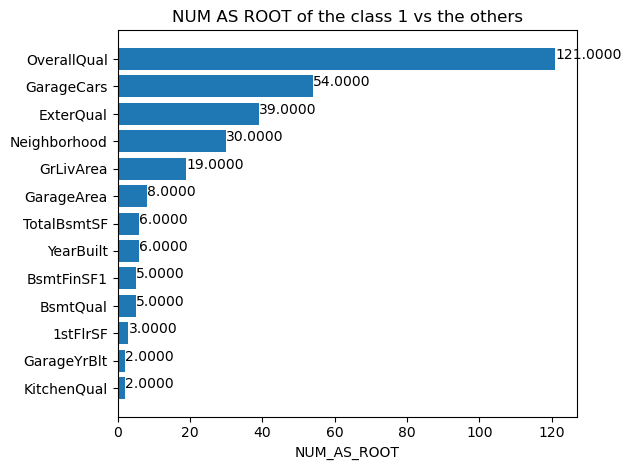

In [26]:
bar = plt.barh(feature_ranks, feature_importances, label = [str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with plt.bar_label() when available
# label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va = "top")
    
plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Submission
Finally predict on the competition test data using the model

In [27]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids, 
                       'SalePrice': preds.squeeze()})
output.head()

2/2 [==============================] - 1s 22ms/step


,Id,SalePrice
0,1461,129650.523438
1,1462,153254.703125
2,1463,185075.859375
3,1464,183516.546875
4,1465,194685.187500


In [28]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index = False)
sample_submission_df.head()

2/2 [==============================] - 0s 21ms/step


,Id,SalePrice
0,1461,129650.523438
1,1462,153254.703125
2,1463,185075.859375
3,1464,183516.546875
4,1465,194685.187500
